In [14]:
# generate read order txt file
import glob
import os
import random

base_dir ="/homeL/1sliu/code/SSL_UNet3D/data/CHAOST2/chaos_MR_T2_normalized"
sup_img_re = "image*.nii.gz" 
sup_label_re = "superpix3d*.nii.gz" 
qry_img_re = "image*.nii.gz" 
qry_label_re = "label*.nii.gz"

sup_img_file = "sup_img_file.txt"
sup_label_file = "sup_label_file.txt"
qry_img_file = "qry_img_file.txt"
qry_label_file = "qry_label_file.txt"


def getNameList(base_dir,data_re):
    data_file_names = []
    for file_name in sorted(glob.glob(os.path.join(base_dir,data_re))):
        data_file_names.append(file_name)
    return data_file_names

def writeNameFile(lines, base_dir, write_with_file_name="None.txt"):
    file_path = os.path.join(base_dir,write_with_file_name)
    with open(file_path,'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

sup_img_names = getNameList(base_dir, sup_img_re)
sup_label_names = getNameList(base_dir, sup_label_re)

# with original order
qry_img_names = getNameList(base_dir, qry_img_re)
qry_label_names = getNameList(base_dir, qry_label_re)

writeNameFile(sup_img_names,base_dir,write_with_file_name=sup_img_file)
writeNameFile(sup_label_names,base_dir,write_with_file_name=sup_label_file)
writeNameFile(qry_img_names,base_dir,write_with_file_name=qry_img_file)
writeNameFile(qry_label_names,base_dir,write_with_file_name=qry_label_file)


In [2]:
# Before everythings
import comet_ml

# Create an experiment with your api key
experiment = comet_ml.Experiment(
    api_key="4e45dKB4oaj3YgKFrQ0MhPld1",
    project_name="ssl",
)

from torch.utils.data import Dataset
import SimpleITK as sitk
import torch.nn as nn
from medpy.io import load
import torchio as tio
import nibabel as nib
import numpy
from pytorch3dunet.datasets.utils import SliceBuilder 



def read_text_file(filename):
    lines = []
    # print(f"start to read text file:{filename}")
    with open(filename, 'r') as file:
        for line in file: 
            # print(f"line:{line}")
            line = line.strip() #or some other preprocessing
            lines.append(line)
    # print(f"length of text file:{len(lines)}")
    return lines

def nii_read(filename):
    # print(f"nii_resad:{filename}")
    # voxel_obj =  sitk.ReadImage(filename)
    # print(voxel_obj)
    # voxel_arr = sitk.GetArrayFromImage(voxel_obj) 
    # print(voxel_arr.shape)
    voxel_arr,voxel_header = load(filename)
    voxel_arr = numpy.swapaxes(voxel_arr,0,2)
    return voxel_arr
########
# # test nii_read code
# import numpy
# import torchio.transforms as transforms
# test_data_file = "./data/CHAOST2/chaos_MR_T2_normalized/image_1.nii.gz"
# vox_arr = nii_read(test_data_file)
# print(vox_arr.shape)
# swap_ax =numpy.swapaxes(vox_arr,0,2)
# cut_depth = swap_ax[:31,:,:]
# add_di = cut_depth[None,:]
# print(add_di.shape)
# result = torch.as_tensor(add_di)
# print(result.shape)

#########

class SSLDataset(Dataset):
    def __init__(self, root_dir, sup_file, sup_label_file, qry_file, qry_label_file):
        self.root_dir = root_dir
        self.sup_file = read_text_file(os.path.join(self.root_dir, sup_file))
        self.sup_label_file = read_text_file(os.path.join(self.root_dir , sup_label_file))
        self.qry_file = read_text_file(os.path.join(self.root_dir , qry_file))
        self.qry_label_file = read_text_file(os.path.join(self.root_dir , qry_label_file))
        self.same_depth = 30
        self.adaptive_size = (30,64,64)
        # self.adaptive_size = (15,32,32)
        assert len(self.sup_file) == len(self.sup_label_file), "lengths of image files and fixation files do not match!"

    def __len__(self):
        return len(self.sup_file)

    def __getitem__(self, idx):
        
        sup_img = self.compose_action(self.qry_file[idx])
        sup_label_fg = self.compose_action(self.qry_label_file[idx])
        sup_label_bg = torch.subtract(torch.ones_like(sup_label_fg), sup_label_fg)

        
        #qry_img = self.compose_transformation(self.qry_file[idx])
        #qry_label_fg = self.compose_transformation(self.qry_label_file[idx])
        
    
        qry_img = self.compose_transformation(self.qry_file[idx])
        qry_label_fg = self.compose_transformation(self.qry_label_file[idx])
        qry_label_bg = torch.subtract(torch.ones_like(qry_label_fg),  qry_label_fg)

        sample = {"sup_img":sup_img, "sup_fg_label":sup_label_fg, "qry_img":qry_img, "qry_label_fg":qry_label_fg,
         "sup_bg_label":sup_label_bg, "qry_label_bg":qry_label_bg}

        return sample
    
   

    def compose_action(self, file_name):
        # read data as numpy array 3d
        data = self.nii_read_and_cut(file_name)
        

        # Add another dummpy dimention for channel as 1
        data = data[None,:]
        # [1,same_depth, 256,256]

        # To tensor
        data = torch.as_tensor(data,dtype=torch.double)

        # Avgpool
        # ap = nn.AvgPool3d((2, 2, 1), stride=(2, 2, 2))
        ap = nn.AdaptiveAvgPool3d(self.adaptive_size)
        # ap = nn.AdaptiveAvgPool3d((None,64,64))
        data = ap(data)
        # [1, same_depteh, 128, 128]

        return data


    def compose_transformation(self, file_name):

        data = sitk.ReadImage(file_name)

        elastic_tr = tio.RandomElasticDeformation(num_control_points=7,locked_borders=2)
        affine_tr = tio.transforms.RandomAffine(scales=(0.5, 1.5),degrees=(10,10,10))
        gamma_tr = tio.RandomGamma(log_gamma=(-0.3,0.3))

        ts = tio.Compose([gamma_tr,affine_tr,elastic_tr])

        transformed = ts(data)
        array = sitk.GetArrayFromImage(transformed)
        # sitk.WriteImage(transformed,"transformed_data.nii.gz")
# To tensor
        array = array[None,:]
        data = torch.as_tensor(array,dtype=torch.double)        


        # Avgpool
        # ap = nn.AvgPool3d((2, 2, 1), stride=(2, 2, 2))
        ap = nn.AdaptiveAvgPool3d(self.adaptive_size)
        # ap = nn.AdaptiveAvgPool3d((None,64,64))
        data = ap(data)
        # [1, same_depteh, 128, 128]

        return data
        
    
    def nii_read_and_cut(self, file_name):

        # numpy.array 3D
        data = nii_read(filename=file_name)
        # cut depth the same as same_depth
        data = data[:self.same_depth,:,:]

        return data
    
    



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fabzhang/ssl/5286ab260b83403fa9716ebb506c0638

/homeL/1sliu/anaconda3/envs/unet3d/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import pytorch_lightning as pl
import pytorch3dunet.unet3d.model as model3dUnet
import torch.nn.functional as F
import torch


class SSL3DUNet(pl.LightningModule):
    def __init__(self,batch_size = 1, lr=1e-3):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = lr
        # self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.BCEWithLogitsLoss()
        self.avgPool = nn.AdaptiveAvgPool3d((None,8,8))
        self.thresh = .95
        unet3d = model3dUnet.UNet3D(1,1)
        self.unet3d = unet3d.double()
        self.params = list(unet3d.parameters())
        self.automatic_optimization = False # use own optimizer
        self.save_hyperparameters() # for comet.ML logger
        print("Finish init SSL3DUNet Model")
    # def forward(batch, batch_idx):
    #     return batch 

    def loss(self, batch, predictions):

        sup_fg_label = batch["sup_fg_label"] 
        sup_bg_label = batch["sup_bg_label"] 
        qry_label_fg = batch["qry_label_fg"]
        qry_label_bg = batch["qry_label_bg"]
        sup_fts = predictions["sup_fts"]
        qry_fts = predictions["qry_fts"]

        qry_pred, sup_pred = self._pass_compose(sup_fts, qry_fts, sup_fg_label, sup_bg_label, qry_label_fg, qry_label_bg)
        sig = nn.Sigmoid() 
        query_loss = self.criterion(sig(qry_pred),sig(qry_label_fg))
        experiment.log_metric("query_loss", query_loss)
        sup_loss = self.criterion(sig(sup_pred),sig(sup_fg_label))
        experiment.log_metric("sup_loss", sup_loss)

        loss = torch.add(query_loss , sup_loss )
        return loss


    def training_step(self,batch, batch_idx):
        opt = self.optimizers()
        # batch: {"sup_img":sup_img, "sup_label":sup_label, "qry_img":qry_img, "qry_label":qry_label}
        
        sup_img = batch["sup_img"] 
        qry_img = batch["qry_img"] 
        
    #   as -> [batch, channel, 30, 128 , 128] 
    #    -> [batch, 1, 30, 128 , 128] 

        sup_fts = self.unet3d(sup_img) 
        qry_fts = self.unet3d(qry_img) 
        predictions = {"sup_fts":sup_fts, "qry_fts":qry_fts} 
        opt.zero_grad()
        loss = self.loss(batch,predictions)
        self.manual_backward(loss)
        opt.step()
        experiment.log_metric("training loss", loss)
        return {"loss":loss} 

    def validation_step(self,batch, batch_idx):
        # batch: {"sup_img":sup_img, "sup_label":sup_label, "qry_img":qry_img, "qry_label":qry_label}
        sup_img = batch["sup_img"] 
        qry_img = batch["qry_img"] 
    #   as -> [batch, channel, 30, 128 , 128] 
    #    -> [batch, 1, 30, 128 , 128] 
        sup_fts = self.unet3d(sup_img) 
        qry_fts = self.unet3d(qry_img) 

        predictions = {"sup_fts":sup_fts, "qry_fts":qry_fts} 
        loss = self.loss(batch,predictions)
        experiment.log_metric("validation loss", loss)
        return {"x":loss} 
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.params, lr=self.learning_rate)
        # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.1)
        return [optimizer]
    
    def _pass_compose(self,sup_fts, qry_fts, sup_fg_label, sup_bg_label, qry_label_fg, qry_label_bg):
        
        raw_score_bg = self._alp_module(qry_fts,sup_fts,sup_bg_label,mode='local',thresh=self.thresh)
        NO_OVER_THRES =  torch.all(torch.flatten(sup_fg_label < self.thresh))
        raw_score_fg = self._alp_module(qry_fts,sup_fts,sup_fg_label,mode='global' if not NO_OVER_THRES else 'mask',thresh=self.thresh)
        qry_pred = torch.div(torch.add(raw_score_bg, raw_score_fg),2)

        re_raw_score_bg = self._alp_module(sup_fts,qry_fts,qry_label_bg,mode='local',thresh=self.thresh)
        RES_NO_OVER_THRES =  torch.all(torch.flatten(qry_label_fg < self.thresh))
        re_raw_score_fg = self._alp_module(sup_fts,qry_fts,qry_label_fg,mode='global' if not RES_NO_OVER_THRES else 'mask',thresh=self.thresh)
        sup_pred = torch.div(torch.add(re_raw_score_bg, re_raw_score_fg),2)

        return qry_pred, sup_pred

    def _alp_module(self, qry_fts, sup_fts, sup_label, mode='global', thresh=.95):
    
        # [1, same_depteh, 16, 16]
        if mode == 'local':
            
            ch = qry_fts.shape[1] # temp: 64

            n_sup_x = self.avgPool(sup_fts)
            sup_nshot = sup_fts.shape[0] # 1

            n_sup_x = n_sup_x.view(sup_nshot,ch,-1).permute(0,2,1).unsqueeze(0)
            n_sup_x = n_sup_x.reshape(1,-1,ch).unsqueeze(0)

            sup_y = self.avgPool(sup_label) 
            sup_y = sup_y.view(sup_nshot,1,-1)
            sup_y = sup_y.permute(1,0,2).view(1,-1).unsqueeze(0)

            pro_n = n_sup_x[sup_y > thresh,:]

            qry_n = self._safe_norm(qry_fts) 

            dists = F.conv3d(qry_n,pro_n[...,None,None,None]) * 20
            pred_grid =  torch.sum(F.softmax(dists,dim=1)*dists, dim=1,keepdim=True)
            return pred_grid
            
        elif mode == 'global':
            
            ch = qry_fts.shape[1] # temp: 64

            n_sup_x = self.avgPool(sup_fts)
            sup_nshot = sup_fts.shape[0] # 1

            n_sup_x = n_sup_x.view(sup_nshot,ch,-1).permute(0,2,1).unsqueeze(0)
            n_sup_x = n_sup_x.reshape(1,-1,ch).unsqueeze(0)

            sup_y = self.avgPool(sup_label) 
            sup_y = sup_y.view(sup_nshot,1,-1)
            sup_y = sup_y.permute(1,0,2).view(1,-1).unsqueeze(0)

            pro_n = n_sup_x[sup_y > thresh,:]

            ##################
            # global
            glb_proto = torch.sum(sup_fts * sup_label, dim=(-1,-2,-3)) / (sup_label.sum(dim=(-1,-2,-3)) + 1e-5)
            pro_n = self._safe_norm(torch.cat([pro_n, glb_proto], dim=0))
            qry_n = self._safe_norm(qry_fts) 
            ##############

            dists = F.conv3d(qry_n,pro_n[...,None,None,None]) * 20
            pred_grid =  torch.sum(F.softmax(dists,dim=1)*dists, dim=1,keepdim=True)
            
            return pred_grid
            
        elif mode == 'mask':
            proto = torch.sum(sup_fts * sup_label, dim=(-1,-2,-3)) / (sup_label.sum(dim=(-1,-2,-3)) + 1e-5)
            proto = proto.mean(dim=0, keepdim=True)
            pred_mask = F.cosine_similarity(qry_fts, proto[..., None,None], dim=1, eps=1e-4) * 20

            return pred_mask.unsqueeze(1)
        else:
            pass

    def _safe_norm(self, input, p=2, dim = 1, eps = 1e-4):
        x_norm = torch.norm(input,p=p,dim=dim)
        x_norm = torch.max(x_norm,torch.ones_like(x_norm,requires_grad=False)*eps )
        output = input.div(x_norm.unsqueeze(1).expand_as(input))
        return output

In [4]:

from torch.utils.data import random_split,DataLoader 
import torchio.transforms as transforms 
from pytorch_lightning.loggers import CometLogger

torch.manual_seed(0) # set default seed for torch operation
dataset = SSLDataset(base_dir,sup_img_file,sup_label_file,qry_img_file,qry_label_file)
train, val = random_split(dataset,[16,4])
model = SSL3DUNet()
comet_logger = CometLogger(
    api_key="4e45dKB4oaj3YgKFrQ0MhPld1",
    rest_api_key="4e45dKB4oaj3YgKFrQ0MhPld1",
    optimizer_data=model.parameters(),
)


# trainer = pl.Trainer(fast_dev_run=False, accelerator='gpu',devices=[1],log_every_n_steps=10, max_epochs=10, max_steps=10,logger=[comet_logger])
trainer = pl.Trainer(fast_dev_run=False, accelerator='gpu',devices=[0,1])
train_loader = DataLoader(train,batch_size=1,num_workers=24)
val_loader = DataLoader(val,batch_size=1,num_workers=24)

print("strat trainning")
trainer.fit(model, train_loader, val_loader )
print("end trainning")

experiment.end()
######################################################################################################## STOP HERE ########################################################

CometLogger will be initialized in online mode


Finish init SSL3DUNet Model


MisconfigurationException: `Trainer(strategy='ddp_spawn')` or `Trainer(accelerator='ddp_spawn')` is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible strategies: Trainer(strategy=None|dp|tpu_spawn). In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

In [15]:

# criterion = nn.BCEWithLogitsLoss()
# avgPool = nn.AdaptiveAvgPool3d((None,8,8))
# thresh = .95
# unet3d = model3dUnet.UNet3D(1,1)
# unet3d_d = unet3d.double()
# params = unet3d.parameters()
model = SSL3DUNet()
# unet3d = model3dUnet.UNet3D(1,1)
import pickle
with open('test.pickle', 'wb') as handle:
    pickle.dump(model,handle)

Finish init SSL3DUNet Model


In [ ]:
# import torch.nn as nn
# import torch
# from torch.nn import functional as F
# # pool of square window of size=3, stride=2
# m = nn.AvgPool3d(3, stride=2)
# # pool of non-square window
# # m = nn.AvgPool3d((2, 2, 1), stride=(2, 2, 2))

# # m = nn.AvgPool3d((4, 4, 1), stride=(1, 4, 4))
# m = nn.AdaptiveAvgPool3d((None,128,128))
# input = torch.randn(1, 32, 32, 32)
# t = torch.randn( 16, 32)
# output = F.conv2d(input, t[...,None,None])*20

# # x_norm = torch.norm(input,p=2,dim=1)
# # x_norm = torch.max(x_norm,torch.ones_like(x_norm)*1e-4 )
# # output = input.div(x_norm.unsqueeze(1).expand_as(input))
# # input = torch.randn(1, 1, 31,256, 256)
# # input = torch.randn(1, 1, 15,128, 128)
# # output = m(input)
# #output = input.squeeze(0)
# print(output.shape)

: 

(1, 24, 128, 128)
(24, 128, 128)
(24, 128, 128)
(24, 128, 128)


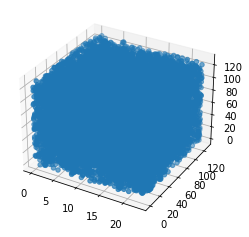

In [31]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
data_arr = np.random.rand(2, 1, 24, 128, 128)
data_arr[0].shape
save_f = data_arr[1]
save_b = data_arr[1]
print(save_f.shape)
save_f = numpy.squeeze(save_f)
print(save_f.shape)
safe_f = save_f[0]
print(save_f.shape)
save_f[np.where(save_f<0.95)] = 0
print(save_f.shape)
xf,yf,zf =save_f.nonzero()
# xb,yb,zb =save_b.nonzero()

fig_f = plt.figure()
ax_f = fig_f.add_subplot(111, projection='3d')
ax_f.scatter(xf,yf,zf)


In [1]:
#
# 2D testing
# 64,15,128,128
# 64, 1, 1, 1 as prototype
#
import torch
from torch.nn import functional as F


def safe_norm( input, p=2, dim = 1, eps = 1e-4):
    x_norm = torch.norm(input,p=p,dim=dim)
    x_norm = torch.max(x_norm,torch.ones_like(x_norm)*eps )
    output = input.div(x_norm.unsqueeze(1).expand_as(input))
    return output


sup_x = torch.randn( 1,256, 32, 32)
sup_y = torch.randn( 1,256, 32, 32)
glb_proto = torch.sum(sup_x * sup_y, dim=(-1,-2)) / (sup_y.sum(dim=(-1,-2)) + 1e-5)
print(glb_proto.shape)


input = torch.randn( 1,256, 16, 16)
qry_n = torch.randn( 1,256, 32, 32)


t1 = input.view(1,256,-1).permute(0,2,1).unsqueeze(0)
print(input.view(1,256,-1).shape)
print(f"t1.shape:{t1.shape}")
t2 = t1.reshape(1,-1,256).unsqueeze(0)
print(f"t2.shape:{t2.shape}")

sup_y = torch.randn( 1,1, 16, 16)
print(f"input shape:{input.shape}")
y1 = sup_y.view(1,1,-1)
print(f"y1 shape:{y1.shape}")
y2 = y1.permute(1,0,2)
print(f"y2 shape:{y2.shape}")
y3 = y2.view(1,-1)
print(f"y3 shpae:{y3.shape}")
y4 = y3.unsqueeze(0)
print(f"y4 shape:{y4.shape}")

pro_n = t2[y4 > 0.95,:]
print(f"pro_n.shape:{pro_n.shape}")

# for global
pro_n = safe_norm(torch.cat([pro_n, glb_proto], dim=0))
print(f"pro_n global shape:{pro_n.shape}")
qry_n = safe_norm(qry_n)
print(f"qry_n global shape:{qry_n.shape}")

dists = F.conv2d(qry_n,pro_n[...,None,None]) * 20
print(f"dists sahpe:{dists.shape}")
pred_grid =  torch.sum(F.softmax(dists,dim=1)*dists, dim=1,keepdim=True)
print(f"pred_grid.shape:{pred_grid.shape}")

sup_pred = torch.cat([pred_grid,], dim=1)





torch.Size([1, 256])
torch.Size([1, 256, 256])
t1.shape:torch.Size([1, 1, 256, 256])
t2.shape:torch.Size([1, 1, 256, 256])
input shape:torch.Size([1, 256, 16, 16])
y1 shape:torch.Size([1, 1, 256])
y2 shape:torch.Size([1, 1, 256])
y3 shpae:torch.Size([1, 256])
y4 shape:torch.Size([1, 1, 256])
pro_n.shape:torch.Size([52, 256])
pro_n global shape:torch.Size([53, 256])
qry_n global shape:torch.Size([1, 256, 32, 32])
dists sahpe:torch.Size([1, 53, 32, 32])
pred_grid.shape:torch.Size([1, 1, 32, 32])


/homeL/1sliu/anaconda3/envs/unet3d/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
import numpy

k_fold = 5
seg = 1
total_data_size = 20
indices = list(range(total_data_size))
base = int(numpy.floor(1/k_fold * total_data_size))
split_start = base * seg 
split_end = base* (seg+1) 
print(base)
print(split_start)
print(split_end)
print(indices[:split_start]+indices[split_end:],indices[split_start:split_end])

4
4
8
[0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [4, 5, 6, 7]


In [ ]:

# ch = 64

# sup_x = torch.randn( 1,ch, 30, 256, 256)
# sup_y = torch.randn( 1,ch, 30, 256, 256)
# glb_proto = torch.sum(sup_x * sup_y, dim=(-1,-2,-3)) / (sup_y.sum(dim=(-1,-2,-3)) + 1e-5)
# print(glb_proto.shape)

# input = torch.randn( 1, ch,30, 16, 16)
# qry_n = torch.randn( 1,ch, 30, 256, 256)


# t1 = input.view(1,ch,-1).permute(0,2,1).unsqueeze(0)
# print(f"t1.shape:{t1.shape}")
# t2 = t1.reshape(1,-1,ch).unsqueeze(0)
# print(f"t2.shape:{t2.shape}")

# nb = 1
# nshot = 1
# sup_y = torch.randn( nshot,nb, 30, 16, 16)
# y1 = sup_y.view(1,1,-1)
# print(f"y1 shape:{y1.shape}")
# y2 = y1.permute(1,0,2)
# print(f"y2 shape:{y2.shape}")
# y3 = y2.view(1,-1)
# print(f"y3 shpae:{y3.shape}")
# y4 = y3.unsqueeze(0)
# print(f"y4 shape:{y4.shape}")

# pro_n = t2[y4 > 0.95,:]
# print(f"pro_n.shape:{pro_n.shape}")


# # for global
# pro_n = safe_norm(torch.cat([pro_n, glb_proto], dim=0))
# print(f"pro_n global shape:{pro_n.shape}")
# qry_n = safe_norm(qry_n)
# print(f"qry_n global shape:{qry_n.shape}")

# dists = F.conv3d(qry_n,pro_n[...,None,None,None]) * 20
# print(f"dists sahpe:{dists.shape}")
# pred_grid =  torch.sum(F.softmax(dists,dim=1)*dists, dim=1,keepdim=True)
# print(f"pred_grid.shape:{pred_grid.shape}")

: 

In [ ]:
# import numpy as np
# import torch
# a = torch.rand(1,3,2,1)
# print(a)
# print(a.shape)
# b = a.argmax(dim=1).unsqueeze(0)
# c = [b==i for i in range(2)]
# c[2]

: 

In [ ]:
# # sup_x = 16*16*256
# # BG_mask = 16*16
# # 
# a = torch.rand(1,1,2,15,32,32)
# a.view(-1,*a[:-4]).shape
# a.view((1,1,1,30,32,32)).shape
# #

: 

In [ ]:
# import torch
# import torch.nn.functional as F

# # Declarations (dummy tensors)
# rgb_im = torch.randint(0, 255, [1, 3, 256, 256])
# depth = torch.randint(0, 400, [1, 1, 256, 256])

# # Calculations
# depth_ohe = F.one_hot(depth, num_classes=400)       # of shape (batch, channel, height, width, binary)
# print(depth_ohe.shape)
# bchwd_tensor = rgb_im.unsqueeze(-1)*depth_ohe       # of shape (batch, channel, height, width, depth)
# print(bchwd_tensor.shape)
# bcdhw_tensor = bchwd_tensor.permute(0, 1, 4, 2, 3)  # of shape (batch, channel, depth, height, width)
# print(bcdhw_tensor.shape)

: 

: 

In [ ]:
from medpy.io import load
import numpy

# copy spacing and orientation info between sitk objects
def copy_info(src, dst):
    dst.SetSpacing(src.GetSpacing())
    dst.SetOrigin(src.GetOrigin())
    dst.SetDirection(src.GetDirection())
    #dst.CopyInfomation(src)
    return dst

def nii_read(filename):
    # print(f"nii_resad:{filename}")
    # voxel_obj =  sitk.ReadImage(filename)
    # print(voxel_obj)
    # voxel_arr = sitk.GetArrayFromImage(voxel_obj) 
    # print(voxel_arr.shape)
    voxel_arr,voxel_header = load(filename)
    voxel_arr = numpy.swapaxes(voxel_arr,0,2)
    return voxel_arr
    
def nii_read_and_cut(file_name):

# numpy.array 3D
    data = nii_read(filename=file_name)
# cut depth the same as same_depth
    data = data[:30,:,:]

    return data

: 

In [ ]:
import torchio as tio
import os
import SimpleITK as sitk
import nibabel as nib
import torch
import torch.nn as nn

elastic_tr = tio.RandomElasticDeformation(
    num_control_points=7,
    locked_borders=2,
)
affine_tr = tio.transforms.RandomAffine(
    scales=(0.5, 1.5),
    degrees=(10,10,10),
)
gamma_tr = tio.RandomGamma(
    log_gamma=(-0.3,0.3)
)

ts = tio.Compose([
    gamma_tr,
    affine_tr,
    elastic_tr,
])

img_path = './data/CHAOST2/chaos_MR_T2_normalized'
img = 'image_1.nii.gz'
file_name = os.path.join(img_path,img)
print(file_name)
# data = nii_read_and_cut(file_name)
data = sitk.ReadImage(file_name)
print(type(data))
# print(data.shape)
# data = data[None,:]
transformed = ts(data)
array = sitk.GetArrayFromImage(transformed)
print(array.shape)
print(type(array))
# print(transformed.shape)
# data = numpy.squeeze(data,axis=0)
# data = numpy.swapaxes(data, 0,2)
# data_img = nib.Nifti1Image(data,numpy.eye(4))
# nib.save(data_img, "transformed_data.nii.gz")
sitk.WriteImage(transformed,"transformed_data.nii.gz")
# To tensor
array = array[None,:]
data = torch.as_tensor(array,dtype=torch.double)

# Avgpool
# ap = nn.AvgPool3d((2, 2, 1), stride=(2, 2, 2))
ap = nn.AdaptiveAvgPool3d((30,32,32))
# ap = nn.AdaptiveAvgPool3d((None,64,64))
data = ap(data)
data = data.detach().numpy()
data = numpy.squeeze(data,axis=0)
data_img = nib.Nifti1Image(data,numpy.eye(4))
nib.save(data_img, "transformed_data_Pool.nii.gz")



: 

In [ ]:

def compose_transformation(self, file_name):

        #if label -> no gamma transform (does it even make a difference?)
        # read data as numpy array 3d
        data = self.nii_read_and_cut(file_name)
        

        # Add another dummpy dimention for channel as 1
        data = data[None,:]
        # [1,same_depth, 256,256]

        # To tensor
        #data = torch.as_tensor(data,dtype=torch.double)
        #TO NII

        elastic_tr = tio.RandomElasticDeformation(num_control_points=7,locked_borders=2)
        affine_tr = tio.transforms.RandomAffine(scales=(0.5, 1.5),degrees=(10,10,10))
        gamma_tr = tio.RandomGamma(log_gamma=(-0.3,0.3))

        ts = tio.Compose([gamma_tr,affine_tr,elastic_tr])

        transformed = ts(data)
        array = sitk.GetArrayFromImage(transformed)
        sitk.WriteImage(transformed,"transformed_data.nii.gz")
# To tensor
        array = array[None,:]
        data = torch.as_tensor(array,dtype=torch.double)        


        # Avgpool
        # ap = nn.AvgPool3d((2, 2, 1), stride=(2, 2, 2))
        ap = nn.AdaptiveAvgPool3d((15,32,32))
        # ap = nn.AdaptiveAvgPool3d((None,64,64))
        data = ap(data)
        # [1, same_depteh, 128, 128]

        return data

: 